In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
from torch.utils.data import  DataLoader
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset, pickle_write, pickle_read
from dataset.normalization import  ZeroMinMax
from dataset.station_dataset import GroundstationDataset
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.LightningModule import LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_scatter
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False

FIGSIZE=(13.33,7.5)
DPI=300

In [3]:
def predictions_to_image(predictions, input_image, config, patch_size):

    y_hat = torch.cat([x[0] for x in predictions]).squeeze()
    y = torch.cat([x[1] for x in predictions]).squeeze()
    lat = torch.cat([x[2][:, 1] for x in predictions])
    lon = torch.cat([x[2][:, 2] for x in predictions])

    img_dim = (len(input_image.lon) - config.patch_size['x'] +1,
               len(input_image.lat) - config.patch_size['y'] +1,)
    
    y_hat = y_hat.reshape(img_dim)
    y = y.reshape(img_dim)
    lat = lat.reshape(img_dim)
    lon = lon.reshape(img_dim)

    y_hat = config.target_transform.inverse(y_hat, ["SIS"])
    y = config.target_transform.inverse(y, ["SIS"])
    lat = config.transform.inverse(lat, ["lat"])
    lon = config.transform.inverse(lon, ["lon"])

    output_image = xarray.DataArray(
        data=y_hat.T,
        # dims=('x','y'),
        coords={"lat": (('lat'), lat[0, :]),
                "lon": (('lon'), lon[:, 0]),},
        attrs=input_image.SIS.attrs,
    )

    output_image.lat.attrs = input_image.lat.attrs
    output_image.lon.attrs = input_image.lon.attrs
    return output_image, y, y_hat


def image_1d_to_2d(arr, dim, patch_size):
    return arr.reshape(
        dim[0] - patch_size["y"] + 1,
        dim[1] - patch_size["x"] + 1,
    )

def plot_comparison_image(output_image, ground_truth_image, extent=None, savefig = True, folder='',):
    nm = ground_truth_image.name
    time = ground_truth_image.time.dt.strftime('%Y%m%d_%H%M').item()
    time_pretty = ground_truth_image.time.dt.strftime('%Y-%m-%d %H:%M').item()
    proj = ccrs.PlateCarree()
    # fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,6), subplot_kw={"projection": proj})
    FIGSIZE=(13.33,7.5)
    DPI=120
    fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
    gs = fig.add_gridspec(
        2,
        4,
        width_ratios=(3, 3, 3, .2),
        height_ratios=(3,.125),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.1,
    )
    ax1 = fig.add_subplot(gs[0, 0], projection=proj)
    ax2 = fig.add_subplot(gs[0, 1], projection=proj, sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2], projection=proj, sharex=ax1, sharey=ax1)
    axc1 = fig.add_subplot(gs[1, :2], autoscale_on=False)
    axc2 = fig.add_subplot(gs[:, 3])
    
    ax_text = fig.add_subplot(gs[1,2])
    ax_text.axis('off')
    ax_text.annotate(time_pretty, 
                xycoords='axes fraction',
                xy=[.3, .5])

    output_image.plot.imshow(x='lon', y='lat', 
                             vmin=0, vmax=1100, 
                             ax=ax1, transform=proj, add_colorbar=False)
    ground_truth_image.plot.imshow(x='lon', y='lat', 
                                   vmin=0, vmax=1100, ax=ax2, 
                                   transform=proj, cbar_ax=axc1,
                                  cbar_kwargs={'orientation':'horizontal', 'shrink':0.6, 'aspect':40,'label':'SIS [W/m2]'})
    
    error = output_image - ground_truth_image.reindex_like(output_image, method="nearest")
    error.plot.imshow(ax=ax3, transform=proj, cbar_ax=axc2)
    ax1.set_title("DL")
    ax2.set_title("SARAH3")
    ax3.set_title("$\hat{y} - y$")
    
    gls = {}
    for i, ax in enumerate([ax1,ax2,ax3]):
        ax.coastlines()
        gl = ax.gridlines(draw_labels=True, linewidth=.3)
        gl.top_labels = False
        gl.right_labels = False
        if i>0:
            gl.left_labels = False
        
    if extent is not None:
        ax1.set_xlim([extent[0], extent[2]])
        ax1.set_ylim([extent[1], extent[3]])
    
    if savefig:
        if extent is not None:
            extent_str = '_'.join([str(x) for x in extent])
            fig.savefig(folder  + f'{nm}_comparison_{time}_{extent_str}.png')
        else:
            pass
            fig.savefig(folder + f'{nm}_comparison_{time}.png')

from torchmetrics import R2Score
from sklearn.metrics import r2_score
r2score = R2Score()

def statistics_stations(predictions_stations, save = True, plot_text=True, stations_collection='BSRN'):
    predictions_stations_new = predictions_stations.copy()
    metrics_fn = inference_fn + f'{stations_collection}_metrics.txt'
    if save:
        with open(metrics_fn, 'w')as f:
            f.write('#station;bias;RMSE;MAE;R2\n')
            f.write('#-;w/m2;w/m2;w/m2;-\n')
    for key, val in predictions_stations.items():
        y_hat = val['y_hat']
        y = val['SIS']
        error = y_hat - y
        nan = ~error.isnull().compute()
        # print(1-nan.sum().item()/error.shape[0], ' ratio of nans')
        error = error[nan]
        y=y[nan]
        y_hat=y_hat[nan]
        bias = error.mean().values
        mae = abs(error).mean().values
        std = error.std().values
        median = np.median(error)
        rmse = np.sqrt((error**2).mean()).values
        R2 = r2_score(y_hat, y)
        val.update({'R2':R2, 'RMSE':rmse, 'MAE':mae, 'Bias':bias})    
        print(f"{key}: \t Bias: {np.round(bias)}\t RMSE: {np.round(rmse)} \t MAE: {np.round(mae)} \t STD: {np.round(std,2)} \t R2score: {np.round(R2, 3)}")
        fig = prediction_error_plot(torch.tensor(y.values), torch.tensor(y_hat.values), title=key)
        if save is True:
            with open(metrics_fn, 'a') as f:
                f.write(f'{key};{np.round(bias,1)};{np.round(rmse,1)};{np.round(mae,1)};{np.round(R2, 3)}\n')
            fig.savefig(inference_fn + f'prediction_error_plot_{key}.png')
    
    R2s = [val['R2'] for val in predictions_stations.values()]
    rmses = [val['RMSE'] for val in predictions_stations.values()]
    maes = [val['MAE'] for val in predictions_stations.values()]
    biass = [val['Bias'] for val in predictions_stations.values()]
    
    rmse_max = np.ceil(np.max(rmses))
    maes_max = np.ceil(np.max(maes))
    
    lats = [val.lat[0].item() for val in predictions_stations.values()]
    lons = [val.lon[0].item() for val in predictions_stations.values()]
    print(lats,lons)
    
    fig1 = plot_station_scatter(lons, lats, rmses, predictions_stations.keys(), 'RMSE', vmin=50, vmax=rmse_max if rmse_max > 125 else 125, plot_text=plot_text)

    fig2 = plot_station_scatter(lons, lats, maes, predictions_stations.keys(), 'MAE', vmin=30, vmax=maes_max if maes_max > 80 else 80, plot_text=plot_text)

    fig3 = plot_station_scatter(lons, lats, biass, predictions_stations.keys(), 'Bias', cmap='bwr', norm=colors.CenteredNorm(), plot_text=plot_text)
    if save:
        fig1.savefig(inference_fn + f'{stations_collection}_RMSE_plot.png')
        fig2.savefig(inference_fn + f'{stations_collection}_MAE_plot.png')
        fig3.savefig(inference_fn + f'{stations_collection}_bias_plot.png')
        
    
    


# Config

In [4]:


config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", "SZA", "AZI"],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
}
config = SimpleNamespace(**config)



# Trainer and Model

In [17]:
# estimator = LitEstimator()
trainer = Trainer(
    # profiler="simple",
    # num_sanity_val_steps=2,
    accelerator="gpu",
    devices=1,
    precision="32",
)



# chkpt_fn = "../train/SIS_point_estimation/vh232f2j/checkpoints/epoch=11-step=11928.ckpt"
# chkpt_fn = '../train/SIS_point_estimation/wv1ykh5d/checkpoints/epoch=8-step=8946.ckpt' # SARAH3 emulator
# chkpt_fn = '../train/SIS_point_estimation_groundstation/1otg6d0w/checkpoints/epoch=3-val_loss=0.01542.ckpt' # trained on 80 DWD groundstations
# chkpt_fn = '../train/SIS_point_estimation_groundstation/4krccmyz/checkpoints/epoch=0-val_loss=0.09168.ckpt' # retrained for bias on SARAH3


# chkpt_fn = '../train/SIS_point_estimation/4nbyae30/checkpoints/epoch=7-val_loss=0.01023.ckpt'# SARAH3 emulator
# chkpt_fn = '../train/SIS_point_estimation_groundstation/pl86of1b/checkpoints/epoch=4-val_loss=0.01630.ckpt' # finetuned on 80 DWD groundstations
# chkpt_fn = '../train/SIS_point_estimation_groundstation/groundstations_only/checkpoints/epoch=10-val_loss=0.01703.ckpt' # trained only on 80 DWD groundstations
# chkpt_fn = '../train/SIS_point_estimation_groundstation/ld18qnr7/checkpoints/epoch=19-step=14020.ckpt'# Finetuned for 19 epoch but with parameter loss
# chkpt_fn = '../train/SIS_point_estimation_groundstation/mps1bagn/checkpoints/epoch=0-val_loss=0.01839.ckpt' # finetuned for 1 epoch with parameter loss
# chkpt_fn = '../train/SIS_point_estimation_groundstation/wu24vik3/checkpoints/epoch=8-val_loss=0.01883.ckpt' # finetuned on BSRN
# chkpt_fn = '../train/SIS_point_estimation_groundstation/ulw5nuu8/checkpoints/epoch=0-val_loss=0.01874.ckpt' # finetuned for 9 epoch DWD with high parameter loss
chkpt_fn = '../train/SIS_point_estimation_groundstation/drvowqn4/checkpoints/epoch=0-val_loss=0.01659.ckpt' # finetuned DWD, freeze MLP


inference_fn = chkpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

    
estimator = LitEstimatorPoint.load_from_checkpoint(
    chkpt_fn,
    learning_rate=0.001,
    config=config,
)
print(chkpt_fn)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


../train/SIS_point_estimation_groundstation/drvowqn4/checkpoints/epoch=0-val_loss=0.01659.ckpt


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


# Station dataset

In [18]:

def predictions_to_dict(names, datasets):
    predictions_stations = [trainer.predict(estimator, DataLoader(ds, 2048, shuffle=False)) for ds in datasets]
    
    timeindices_l = [ds.timeindices for ds in datasets]
    data_l = [ds.data for ds in datasets]
    
    predictions_dict = { nm: {'y_hat': config.transform.inverse(torch.cat([p[0] for p in pred]), config.y_vars),
                              'y': config.transform.inverse(torch.cat([p[1] for p in pred]), config.y_vars),
                              'x': config.transform.inverse(torch.cat([p[2] for p in pred]), config.x_features),
                             'time': tidx,
                             'data':data} for nm, pred, tidx in zip(names, predictions_stations, timeindices_l, data_l)}
    
    
    return predictions_dict

def predictions_to_ds(names, datasets):
    
    pred_ds = {}
    for nm, ds, in zip(names, datasets):
        data = ds.data
        pred = trainer.predict(estimator, DataLoader(ds, 2048, shuffle=False))
        
        y_hat = config.transform.inverse(torch.cat([p[0] for p in pred]), config.y_vars)
        
        data['y_hat'] = (('time'), y_hat.squeeze())
        pred_ds[nm] = data.drop_vars(['channel_data'])
    return pred_ds
        

## BSRN

In [ ]:
zarr_fns = glob('../../ZARR/IEA_PVPS/IEA_PVPS-*.zarr')
station_names_bsrn = [os.path.basename(fn).split('IEA_PVPS-')[-1].split('.')[0] for fn in zarr_fns]
index = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/IEA_PVPS/index.nc')


a = index.plot.scatter(x='longitude', y='latitude', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
# index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
ax = a.axes
for i, txt in enumerate(index.station_name):
    ax.annotate(txt.values, (index.longitude[i], index.latitude[i]))
ax.set_extent([-8, 28, 29, 62])
ax.set_xlim([-8, 29])
ax.set_ylim([28, 62])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)


plt.show()


In [ ]:
bsrn_datasets = [GroundstationDataset2(f'../../ZARR/IEA_PVPS/IEA_PVPS-{x}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(station_names_bsrn)]

In [ ]:
# predictions_bsrn = predictions_to_dict(station_names_bsrn, bsrn_datasets)

pred_fn = inference_fn + 'BSRN_predictions.pkl'
print(pred_fn)

if not os.path.exists(pred_fn):
    predictions_bsrn = predictions_to_ds(station_names_bsrn, bsrn_datasets)
    pickle_write(predictions_bsrn, pred_fn)
else:
    predictions_bsrn = pickle_read(pred_fn)

In [20]:
baseline_bsrn = pickle_read('BSRN_baseline_predictions.pkl')


In [ ]:
station_nm = 'TOR'

sarahy = baseline_bsrn[station_nm]['y_hat']

ds = predictions_bsrn[station_nm]
ds['sarahy'] = (('time'), sarahy.squeeze())
                               

dt =  datetime(2017,7,10,)   

fig = plt.figure()
ds_sel = ds.sel(time=slice(dt, dt + timedelta(days=1)))
lns1 = ds_sel.SIS.plot.line(x='time', label='SIS')
lns2 = ds_sel.sarahy.plot.line(x='time', label='SARAH3')
lns3 =ds_sel.y_hat.plot.line(x='time', label='Emulator')
ax = plt.gca()
plt.ylabel('SIS [w/m2]')
twinax = ax.twinx()
lns4 =ds_sel.KI.plot.line(x='time', label='CSI', c='k', linestyle='--', linewidth=.6,  ax=twinax)
twinax.set_ylabel('Clear Sky Index [-]')
twinax.set_ylim([0,1.2])
# ds_sel.GHIcalc.plot.line(x='time', label='GHIcalc')
# ds_sel.DIF.plot.line(x='time', label='DIF')
# ds_sel.DNI.plot.line(x='time', label='DNI')

lns = lns1+lns2+lns3 + lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
plt.title(f'{station_nm}   {dt.date()}')

folder = '/scratch/snx3000/kschuurm/irradiance_estimation/inference/timeseries_plots/'
fig.savefig(folder + f'{station_nm}_{dt.date()}.png')
plt.show()


In [ ]:
print(chkpt_fn)
statistics_stations(predictions_bsrn_ds, save=False, plot_text=True)
plt.show()

## DWD

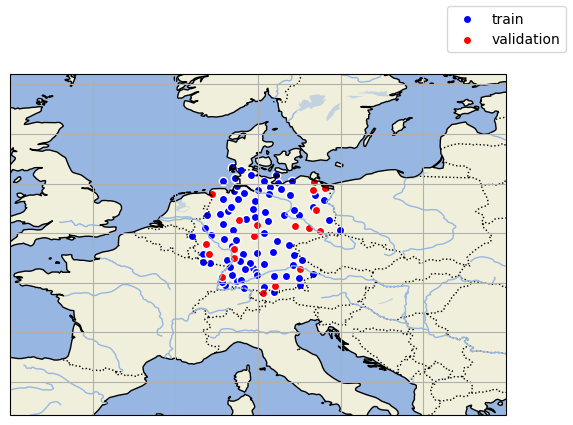

In [80]:
zarr_fns = glob('../../ZARR/DWD/DWD_SOLAR_*.zarr')
station_names = [int(os.path.basename(fn).split('SOLAR_')[-1].split('.')[0]) for fn in zarr_fns]
index = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_index.nc')
index = index.sel(station_id=station_names)

# train_id, valid_id = torch.utils.data.random_split(station_names, [.8, .2])
# print(list(train_id), list(valid_id))

train_id = [15000, 2638, 662, 342, 691, 4104, 1684, 5426, 1766, 3167, 596, 880, 1346, 4271, 1550, 3196, 5792, 2485, 856, 1468, 3287, 4336, 701, 3126, 891, 1078, 4393, 963, 5705, 5546, 7368, 4887, 164, 704, 2261, 656, 2559, 6197, 3513, 3032, 7351, 430, 1443, 2907, 5856, 5404, 6163, 2483, 3268, 2601, 15444, 13674, 7374, 5480, 7367, 4745, 2014, 4625, 5100, 3761, 460, 7369, 3086, 3366, 282, 591, 1639, 232, 4177, 7370, 2667, 4928, 2712, 4466, 5397, 5516, 1975, 1503, 2115, 1605]
valid_id = [1757, 5109, 953, 3028, 2290, 5906, 2171, 427, 2932, 2812, 5839, 1691, 3811, 1420, 5142, 4911, 3660, 3730, 1048]

index_train = index.sel(station_id=train_id); index_valid = index.sel(station_id=valid_id)

a = index_train.plot.scatter(x='lon', y='lat', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a.axes.gridlines()
a.axes.set_extent([-5, 25, 40, 60])
ax = a.axes
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
plt.gcf().legend(['train', 'validation'])
plt.show()


In [ ]:
valid_datasets = [GroundstationDataset2(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(valid_id)]


In [ ]:
pred_fn = inference_fn + 'DWD_valid_predictions.pkl'
print(pred_fn)

if not os.path.exists(pred_fn):
    predictions_validation = predictions_to_ds(valid_id, valid_datasets)
    pickle_write(predictions_validation, pred_fn)
else:
    predictions_validation = pickle_read(pred_fn)

In [ ]:
statistics_stations(predictions_validation, True, stations_collection='DWD_valid')

In [ ]:
plt.show()

In [ ]:
train_datasets = [GroundstationDataset2(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(train_id)]

In [ ]:
pred_fn = inference_fn + 'DWD_train_predictions.pkl'
print(pred_fn)

if not os.path.exists(pred_fn):
    predictions_train = predictions_to_ds(train_id, train_datasets)
    pickle_write(predictions_train, pred_fn)
else:
    predictions_train = pickle_read(pred_fn)

In [ ]:
statistics_stations(predictions_train, True, stations_collection='DWD_train')
plt.close()

## KNMI

In [ ]:
zarr_fns = glob('../../ZARR/KNMI/KNMI_SOLAR_*.zarr')
station_names_knmi = [os.path.basename(fn).split('KNMI_SOLAR_')[-1].split('.')[0] for fn in zarr_fns]
index = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/KNMI/nc/index.nc')
index = index.sel(station=station_names_knmi)



# index_train = index.sel(station_id=train_id); index_valid = index.sel(station_id=valid_id)

a = index.plot.scatter(x='lon', y='lat', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
# index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a.axes.set_extent([0, 10, 50, 55])
ax = a.axes
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
plt.gcf().legend(['train', 'validation'])
plt.show()

In [ ]:
datasets_knmi = [GroundstationDataset2(f'../../ZARR/KNMI/KNMI_SOLAR_{str(x)}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(station_names_knmi)]

In [ ]:
pred_fn = inference_fn + 'KNMI_predictions.pkl'
print(pred_fn)

if not os.path.exists(pred_fn):
    predictions_knmi = predictions_to_ds(station_names_knmi, datasets_knmi)
    pickle_write(predictions_bsrn, pred_fn)
else:
    predictions_knmi = pickle_read(pred_fn)

In [ ]:
statistics_stations(predictions_knmi, True, stations_collection='KNMI')
plt.close()

# METEOSWISS

In [ ]:
zarr_fns = glob('../../ZARR/METEOSWISS/METEOSWISS_SOLAR_*.zarr')
station_names_meteoswiss = [os.path.basename(fn).split('SOLAR_')[-1].split('.')[0] for fn in zarr_fns]


In [ ]:
datasets_meteoswisss = [GroundstationDataset2(f'../../ZARR/METEOSWISS/METEOSWISS_SOLAR_{str(x)}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(station_names_meteoswiss)]

In [ ]:
pred_fn = inference_fn + 'METEOSWISS_predictions.pkl'
print(pred_fn)

if not os.path.exists(pred_fn):
    predictions_meteoswiss = predictions_to_ds(station_names_meteoswiss, datasets_meteoswisss)
    pickle_write(predictions_meteoswiss, pred_fn)
else:
    predictions_meteoswiss = pickle_read(pred_fn)

In [ ]:
statistics_stations(predictions_meteoswiss, True, stations_collection='METEOSWISS', plot_text = False)

# Full image comparison

In [6]:
imageDataset = ImageDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    batch_in_time=None,
    dtype=torch.float32,
)

dts = imageDataset.timeindices

In [ ]:
a = pd.DatetimeIndex(dts)
a = a[(a.year == 2021) & (a.month == 2) & (a.month == 2) & (a.day > 11) & (a.day<16)]
subset = a.sort_values()
print(subset)
# snow events: 
# 11-12 december 2022 around london
# 8-9 january 2022 germany
# 12-15 feb 2021 germany netherlands




In [ ]:
# pickle_write(subset, 'SIS_comparison_timindices.pkl')

In [ ]:
from dataset.dataset import valid_test_split, pickle_write, pickle_read

# _, subset = valid_test_split(a)
# subsubset = np.random.choice(subset, 10, replace=False)
# subset = a[::100]
subset = pickle_read('SIS_comparison_timindices.pkl')

In [8]:
xarray_datasets = [xarray.open_dataset(fn) for fn in glob('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_10min_*.nc')]

In [9]:
def plot_with_ground_truth(output_image, ground_truth_image, point_data=None, extent=None):
    nm = ground_truth_image.name
    datetime = ground_truth_image.time.values
    time = ground_truth_image.time.dt.strftime('%Y%m%d_%H%M').item()
    time_pretty = ground_truth_image.time.dt.strftime('%Y-%m-%d %H:%M').item()
    proj = ccrs.PlateCarree()
    # fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,6), subplot_kw={"projection": proj})
    FIGSIZE=(13.33,7.5)
    DPI=120
    fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
    gs = fig.add_gridspec(
        2,
        4,
        width_ratios=(3, 3, 3, .2),
        height_ratios=(3,.125),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.1,
    )
    ax1 = fig.add_subplot(gs[0, 0], projection=proj)
    ax2 = fig.add_subplot(gs[0, 1], projection=proj, sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2], projection=proj, sharex=ax1, sharey=ax1)
    axc1 = fig.add_subplot(gs[1, :2], autoscale_on=False)
    axc2 = fig.add_subplot(gs[:, 3])
    
    ax_text = fig.add_subplot(gs[1,2])
    ax_text.axis('off')
    ax_text.annotate(time_pretty, 
                xycoords='axes fraction',
                xy=[.3, .5])
    
    vmin = 0
    vmax = ground_truth_image.max() + 100

    output_image.plot.imshow(x='lon', y='lat', 
                             vmin=0, vmax=vmax, 
                             ax=ax1, transform=proj, add_colorbar=False)
    ground_truth_image.plot.imshow(x='lon', y='lat', 
                                   vmin=0, vmax=vmax, ax=ax2, 
                                   transform=proj, cbar_ax=axc1,
                                  cbar_kwargs={'orientation':'horizontal', 'shrink':0.6, 'aspect':40,'label':'SIS [W/m2]'})
    
    norm = colors.TwoSlopeNorm(0, vmin=-100, vmax=100)
    dt_10min = datetime - np.timedelta64(10, 'm')
    for ds in point_data:
        if datetime in ds.time:
            ds['GHI'] = ds['GS_10']*1e4/(10*60)
            ds = ds.sel(time=datetime)
            if isinstance(ds.time.values, np.ndarray):
                ds = ds.isel(time=0)
            ax3.scatter(ds['lon'], ds['lat'], c=ds['GHI'], vmin=0, vmax=vmax, s=100)
            
            ghi_gt = ground_truth_image.sel(lat=ds.lat, lon=ds.lon, method='nearest').values
            ghi_dl = output_image.sel(lat=ds.lat, lon=ds.lon, method='nearest').values
            
            ax1.scatter(ds['lon'], ds['lat'], c=ghi_dl - ds['GHI'], s=50, norm=norm, cmap='bwr')
            a = ax2.scatter(ds['lon'], ds['lat'], c=ghi_gt - ds['GHI'], s=50, norm=norm, cmap='bwr')
    plt.colorbar(a, cax=axc2, label='$\hat{y} - y$')
            
            
    ax1.set_title("DL")
    ax2.set_title("SARAH3")
    ax3.set_title("Groundstations")
    
    gls = {}
    for i, ax in enumerate([ax1,ax2,ax3]):
        ax.coastlines()
        # gl = ax.gridlines(draw_labels=True, linewidth=0)
        # gl.top_labels = False
        # gl.right_labels = False
        # if i>0:
        #     gl.left_labels = False
        
    if extent is not None:
        ax1.set_xlim([extent[0], extent[2]])
        ax1.set_ylim([extent[1], extent[3]])

    return fig
        
def load_or_predict_data(dt, imageDataset, folder):
    fn = folder + f'predictions_{time_str}.pkl'
    if not os.path.exists(fn):
        dataset = imageDataset.load_singleImageDataset_generator(dt=dt).result()

        dataloader = DataLoader(dataset, batch_size=1028, num_workers=20)
        predictions = trainer.predict(estimator, dataloader)


        output_image, y, y_hat = predictions_to_image(
            predictions, dataset.sarah, config, config.patch_size
        )
        sarah3_SIS = dataset.sarah.SIS.load()
        predictions_pkl = {'sarah3':sarah3_SIS, 'dl': output_image}
        pickle_write(predictions_pkl, fn)
    else:
        predictions = pickle_read(fn)
        sarah3_SIS = predictions['sarah3']
        output_image = predictions['dl']
        sarah3_SIS = sarah3_SIS.reindex_like(output_image, method='nearest')
        y = sarah3_SIS.values
        y_hat = output_image.values
    
    return output_image, sarah3_SIS, y, y_hat

In [ ]:
from dataset.dataset import valid_test_split, pickle_write, pickle_read
import traceback
print(inference_fn)
for dt in tqdm(subset):
    try:
        
        folder = inference_fn + 'image_predictions/'
        time_str = dt.strftime('%Y%m%d_%H%M')
        os.makedirs(folder, exist_ok=True)
        output_image, sarah3_SIS, y, y_hat = load_or_predict_data(dt, imageDataset, folder)
        
        
        plot_comparison_image(output_image, sarah3_SIS, folder = folder)#, extent=[-3,50,2,55])
        
        extent = [5, 46.5,15,56.5]
        fig = plot_with_ground_truth(output_image, sarah3_SIS, xarray_datasets, extent=extent)
        extent_str = '_'.join([str(x) for x in extent])
        fig.savefig(folder + f'SIS_groundtruth_{time_str}_{extent_str}.png')
        
        fig = prediction_error_plot(y.flatten(), y_hat.flatten())
        fig.savefig(folder + f'prediction_error_plot_{time_str}.png')
        
        plt.close()
    except Exception as e:
        print(dt)
        print(traceback.format_exc())
        

In [ ]:
plot_with_ground_truth(output_image, sarah3_SIS, xarray_datasets, extent=[5, 46.5,15,56.5])

In [ ]:
import traceback
from dataset.dataset import pickle_read, pickle_write
for dt in tqdm(subset):
    try:
        dataset = imageDataset.load_singleImageDataset_generator(dt=dt).result()
        

        time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
        folder = inference_fn + 'image_predictions/'
        fn = folder + f'predictions_{time_str}.pkl'
        os.makedirs(folder, exist_ok=True)
        if not os.path.exists(fn):
            print('pickling prediction')
            dataloader = DataLoader(dataset, batch_size=2048, num_workers=3)
            predictions = trainer.predict(estimator, dataloader)
            
            
            output_image, y, y_hat = predictions_to_image(
                predictions, dataset.sarah, config, config.patch_size
            )
            sarah3_SIS = dataset.sarah.isel(time=0).SIS.load()
            predictions_pkl = {'sarah3':sarah3_SIS, 'dl': output_image}
            pickle_write(predictions_pkl, fn)
        else:
            predictions = pickle_read(fn)
            sarah3_SIS = predictions['sarah3']
            output_image = predictions['dl']
            sarah3_SIS = sarah3_SIS.reindex_like(output_image, method='nearest')
            y = sarah3_SIS.values
            y_hat = output_image.values
        
#         plot_comparison_image(output_image, sarah3_SIS, folder = folder)#, extent=[-3,50,2,55])

#         fig = prediction_error_plot(y.flatten(), y_hat.flatten())
#         time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
#         fig.savefig(folder + f'prediction_error_plot_{time_str}.png')
    except Exception as e:
        print(dt)
        print(traceback.format_exc())
        

In [ ]:
output_image

In [11]:
dataset = imageDataset.load_singleImageDataset_generator(dt=subset[60]).result()

In [ ]:
dataloader = DataLoader(dataset, batch_size=1024, num_workers=20)
predictions = trainer.predict(estimator, dataloader)

In [24]:
output_image, y, y_hat = predictions_to_image(
    predictions, dataset.sarah, config, config.patch_size
)

In [ ]:
plot_comparison_image(output_image, dataset.sarah.SIS)#, extent=[5, 40, 15,50])

fig = prediction_error_plot(y.flatten(), y_hat.flatten())
time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
# fig.savefig(inference_fn + f'prediction_error_plot_{time_str}.png')

In [ ]:
import gc
gc.collect()

In [ ]:
os.path.exists('/scratch/snx3000/kschuurm/ZARR/SARAH3.zip')